# Author
   > StudentID: 2016003472<br>
   > Name: Nam Hye In(남혜인)<br>
<hr/>

# contents
> 1. Loading data<br>
> <br>
>2. Proof correlation between gene expression and breast cancer<br>
><br>
>3. Feature selection 
    -variance and mean<br>
    -Model based feature selection(L1-regularization, SBS)<br>
><br>
>4. Training with selected genes<br>
    -logistic Regression<br>
    -KNN<br>
    -Random Forest<br>
    -Decision Tree<br>
    -Majority Voting<br>
><br>
>5. Selected Genes Information
<hr/>

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import dendrogram
from sklearn.pipeline import _name_estimators
from sklearn.metrics import confusion_matrix
from scipy.cluster.hierarchy import linkage
from sklearn.metrics import accuracy_score
from sklearn.base import ClassifierMixin
from scipy.spatial.distance import pdist
from pandas import DataFrame, set_option
from sklearn.base import BaseEstimator
from sklearn.decomposition import PCA
from itertools import combinations
from sklearn.externals import six
from sklearn.utils import shuffle
from sklearn.base import clone
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import operator


<hr/>

# 1. Loading data

```Load gene expression data and clinical data, and reset index by replace duplicate data with an mean of data```


In [2]:
# Load
file = r'./breatcancer_expr.xls'
expr = pd.read_excel(file)
file = r'./breatcancer_clinical.xls'
clin = pd.read_excel(file, index_col = 0)

# duplicate data to mean of them
expr = expr.groupby('genename').mean().reset_index()

# set index to genename
data = expr.set_index("genename").T

# drop Nan row
data = data.join(clin['grade'])
data.dropna(axis=0,inplace=True)

# 2. Correlation between gene expression and breast cancer

```To find the correlation between gene expression and breast cancer, I learn data with PCA and Logistic regression. The probability of prediction(59.5%) is about tiwce as high as the probability of being randomly predict(33%). Therefore, the expression level of the gene in the incidence of breast cancer may be significant```

In [3]:
# split train, test data
X, y = data.drop('grade', axis=1), data['grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# standardize
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

#PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

#Predict with logistic regression
lr = LogisticRegression(solver='liblinear', multi_class='auto')
lr = lr.fit(X_train_pca, y_train)

print('Test accuracy:', lr.score(X_test_pca, y_test))

Test accuracy: 0.5945945945945946


```Learning and prediction using PCA and Logistic regression proved the correlation between the onset of breast cancer and the gene. When hierarchical clustering of data, grade1 and grade2 are relatively close than grade3. In this way, we can expect that gene expression is similar to grade1 and grade2 but different from grade3.```

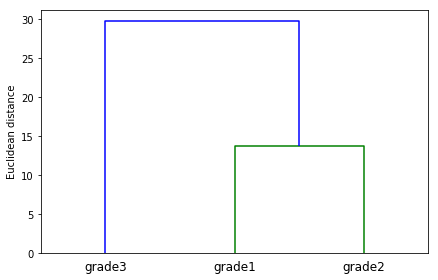

In [4]:
# hierarchical clusetering
col =  data.columns
row = ['grade1', 'grade2', 'grade3'] 
X = data.groupby('grade').mean()
row_clusters = linkage(pdist(X, metric='euclidean'), method='complete')
row_dendr = dendrogram(row_clusters, labels=row)
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()

# 3. Feature Selection

### i ) Removing small variance genes in the entire dataset

```The small variance in the overall data means there is no difference in gene expression between groups. That is the differecne between the average of each group is small. Therefore the gene can be considered meaningless.```

In [5]:
# drop gene which variance is less the 0.2
# 0.2 is the average of the total variance
data_key = data.columns

for key in data_key:
    if key != 'grade' and np.var(data[key]) < 0.2:
        data.drop(key, axis=1, inplace=True)

### ii ) Removing large variance genes within the group
```If a gene has a large variance in a group, gene expression is evenly distributed and that means there is no great significance.```

In [6]:
# classify the group
group1 = data.loc[data['grade'] == 1].copy()
group2 = data.loc[data['grade'] == 2].copy()
group3 = data.loc[data['grade'] == 3].copy()


# drop gene if variance of gene within group 
#                is smaller than average of overall variance
line1 = np.mean(np.var(group1))
line2 = np.mean(np.var(group2))
line3 = np.mean(np.var(group3))

data_key = data.columns

for key in data_key:
    if (np.var(group2[key]) > line2 or np.var(group1[key]) > line1 or np.var(group3[key]) > line3) and key != 'grade':
        group1.drop(key, axis=1, inplace=True)    
        group2.drop(key, axis=1, inplace=True)        
        group3.drop(key, axis=1, inplace=True)        
        data.drop(key, axis=1, inplace=True)

In [7]:
# split train, test data
X = data.drop('grade', axis=1)
y = data['grade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train_std = (X_train - np.mean(X_train))/np.std(X_train)
X_test_std = (X_test - np.mean(X_test))/np.std(X_test)

#### visualization

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


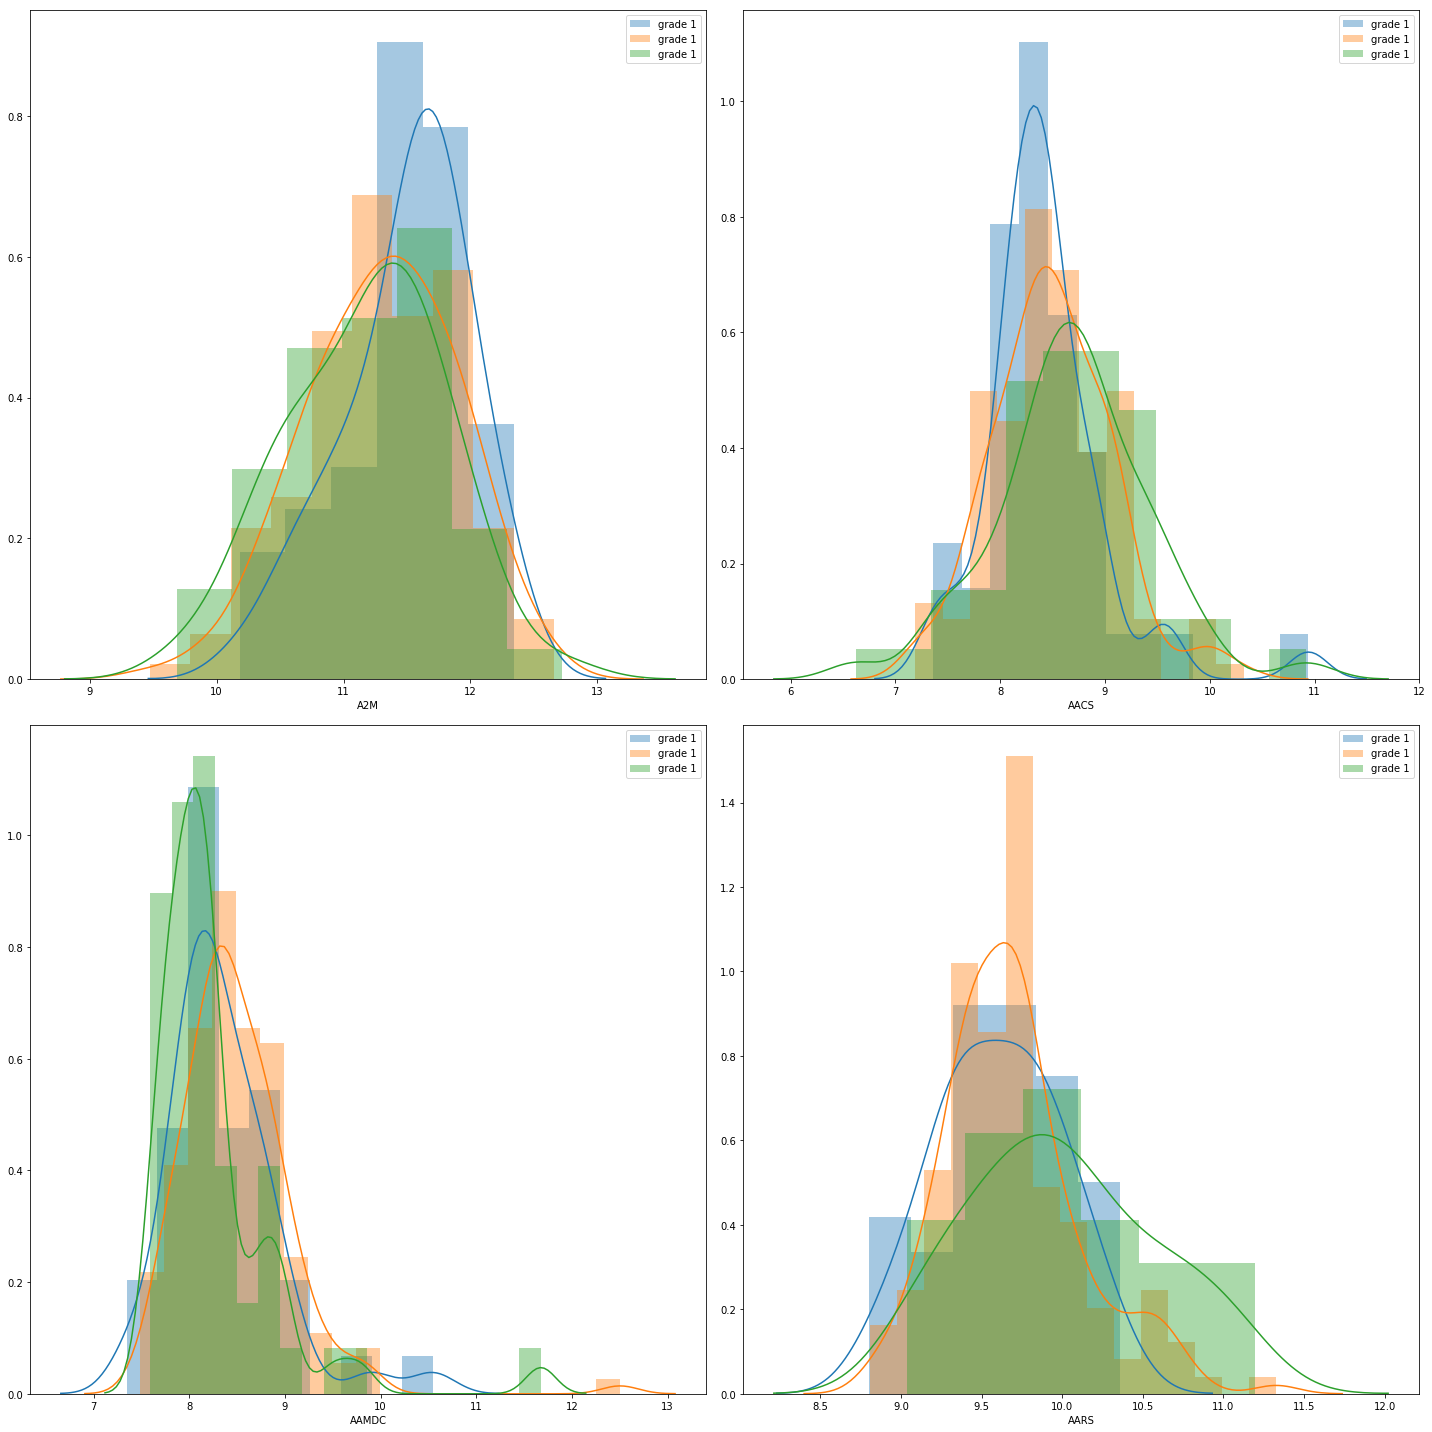

In [8]:
# plot the distribution of the gene expression 
data_key = data.columns

plt.figure(figsize=(20,20))

for i in range(4):    
    plt.subplot(2,2, i+1)
    
    sns.distplot(group1[data_key[i]], label = 'grade 1')
    sns.distplot(group2[data_key[i]], label = 'grade 1')
    sns.distplot(group3[data_key[i]], label = 'grade 1')
    
    plt.legend(loc = "upper right")
    
plt.tight_layout()
plt.show()

###     iii) L1-regularization
```To remove statistical redundancy in feature, I use L1-regularization first. First, find the weight which has highest test accuracy, and then remove the gene columns if weight is 0.```

In [9]:
# find the weight which has the best trainig accuracy
weights, params = [], []
for c in np.arange(0., 10.):
    lr = LogisticRegression(solver='liblinear', multi_class='auto', penalty='l1', C=10.**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)
    print('Test accuracy with c =', 10**c ,': ', lr.score(X_test_std, y_test))
weights = np.array(weights)

Test accuracy with c = 1.0 :  0.7027027027027027
Test accuracy with c = 10.0 :  0.7027027027027027
Test accuracy with c = 100.0 :  0.7027027027027027
Test accuracy with c = 1000.0 :  0.6891891891891891
Test accuracy with c = 10000.0 :  0.7027027027027027
Test accuracy with c = 100000.0 :  0.7027027027027027
Test accuracy with c = 1000000.0 :  0.7027027027027027
Test accuracy with c = 10000000.0 :  0.7027027027027027
Test accuracy with c = 100000000.0 :  0.7027027027027027
Test accuracy with c = 1000000000.0 :  0.7027027027027027


In [10]:
# drop the gene if the weight is 0
lr_train_std = X_train_std.join(y_train)
lr_test_std = X_test_std.join(y_test)

for i in range(weights.shape[1]):
    if(weights[2][i] == 0):
        lr_train_std.drop(data_key[i], axis=1, inplace=True)
        lr_test_std.drop(data_key[i], axis=1, inplace=True)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


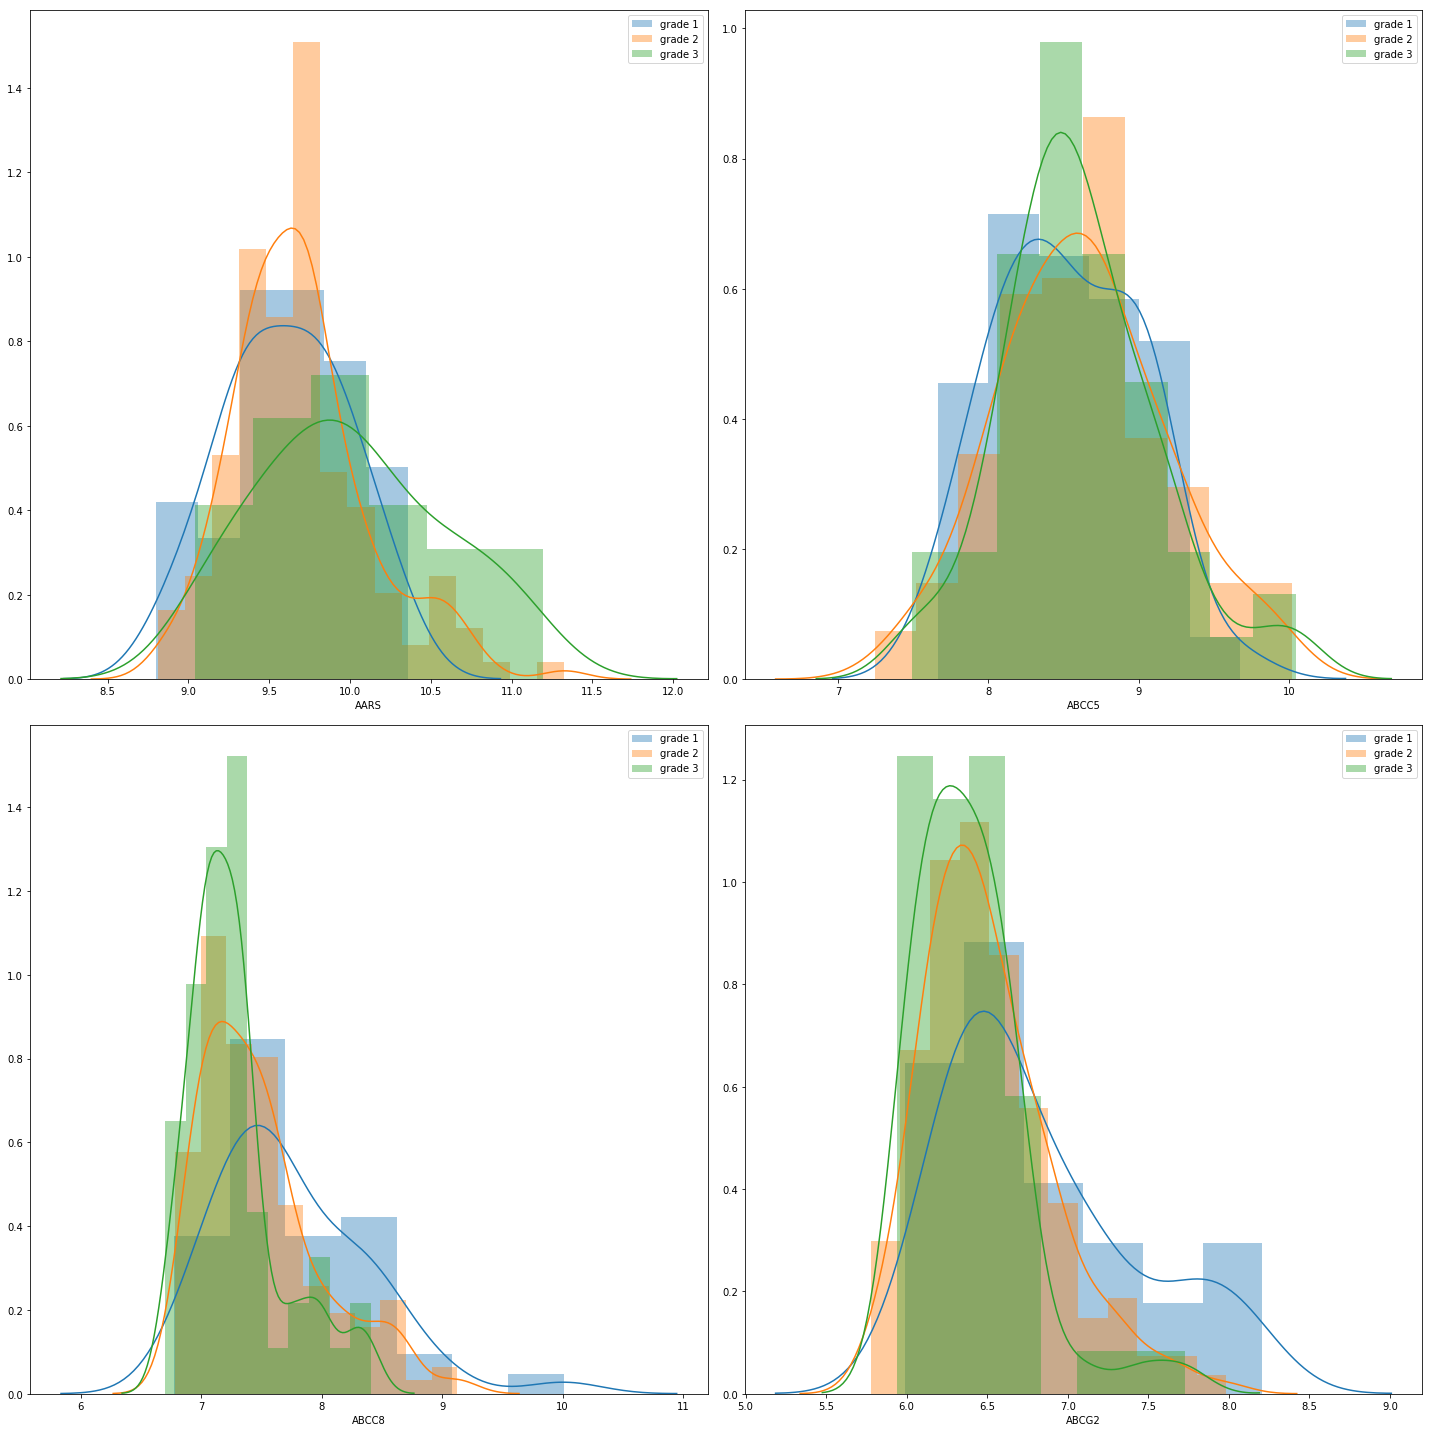

In [11]:
# plot the distribution of the gene expression 
plt.figure(figsize=(20,20))

group1 = data.loc[data['grade'] == 1].copy()
group2 = data.loc[data['grade'] == 2].copy()
group3 = data.loc[data['grade'] == 3].copy()

data_key = lr_train_std.columns

for i in range(4):    
    plt.subplot(2,2, i+1)
    
    sns.distplot(group1[data_key[i]], label = 'grade 1')
    sns.distplot(group2[data_key[i]], label = 'grade 2')
    sns.distplot(group3[data_key[i]], label = 'grade 3')
    
    plt.legend(loc = "upper right")
    
plt.tight_layout()
plt.show()

### iv)  SBS
```I found a subset of features to reduce the generalization error, by removing irrelevant features```


In [12]:
# SBS class
class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
    
    def fit(self, X, y):

        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train,
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

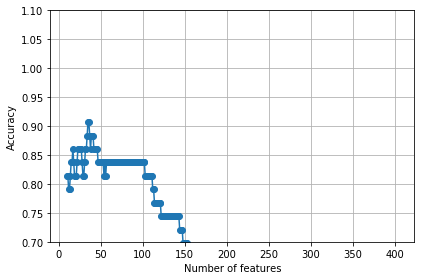

In [13]:
# Declare KNN for sbs
knn = KNeighborsClassifier(n_neighbors=2)

# fit the data after L1-Regularization
sbs = SBS(knn, k_features=10)
sbs.fit(np.array(lr_train_std), y_train)

k_feat = [len(k) for k in sbs.subsets_]

# plot accuracy data
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [14]:
# select the subset with max accuracy
max_score = 0
max_idx = 0
for i in range(len(sbs.scores_)):
    if(sbs.scores_[i] > max_score):
        max_score = sbs.scores_[i]
        max_idx = i
        
# drop the columns that is not in the subset with max accuracy
sbs_result = sbs.subsets_[max_idx]
data_key = lr_train_std.columns

sbs_train_std = lr_train_std.loc[:]
sbs_test_std = lr_test_std.loc[:]
for i in range(lr_train_std.shape[1]):
    if(i not in sbs_result):
        sbs_train_std.drop(data_key[i], axis=1, inplace=True)
        sbs_test_std.drop(data_key[i], axis=1, inplace=True)       

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


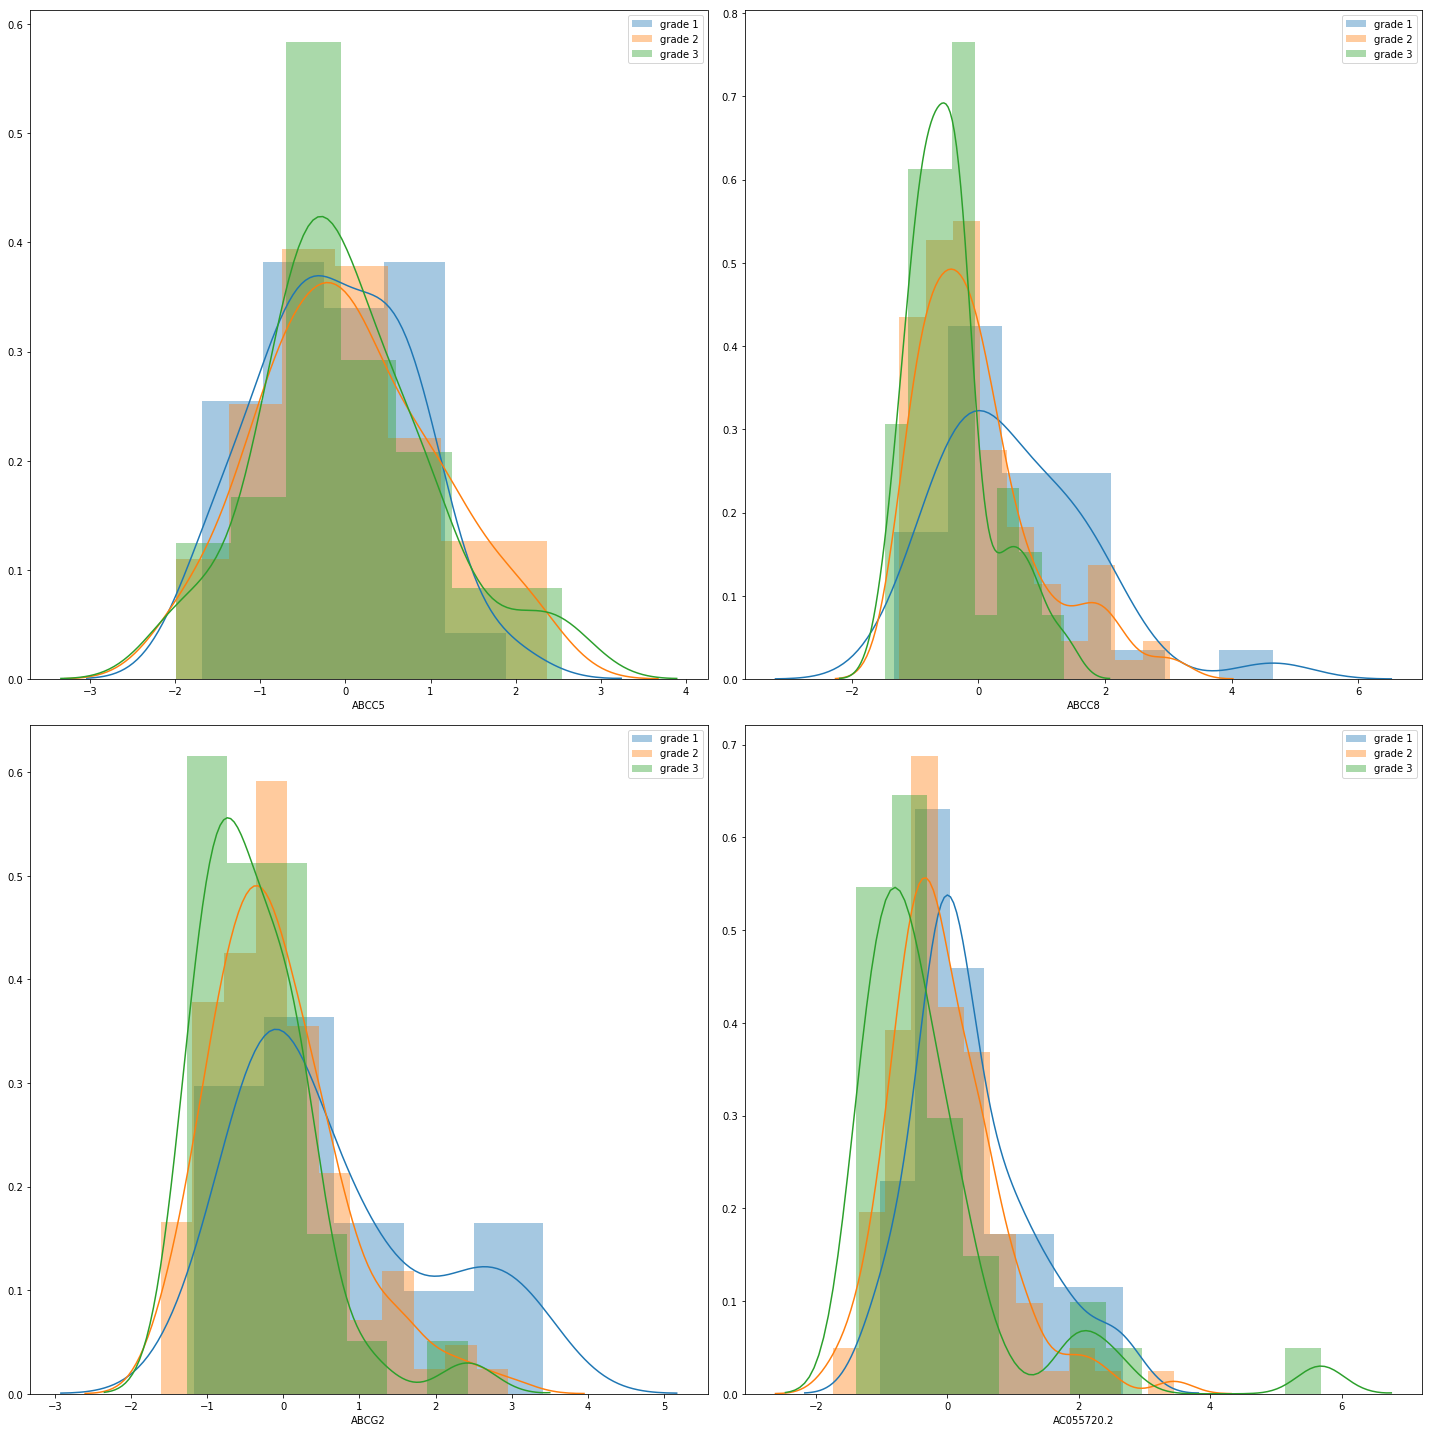

In [15]:
# plot the distribution of the gene expression 
plt.figure(figsize=(20,20))

group1 = sbs_train_std.loc[data['grade'] == 1].copy()
group2 = sbs_train_std.loc[data['grade'] == 2].copy()
group3 = sbs_train_std.loc[data['grade'] == 3].copy()

data_key = sbs_train_std.columns

for i in range(4):    
    plt.subplot(2,2, i+1)
    
    sns.distplot(group1[data_key[i]], label = 'grade 1')
    sns.distplot(group2[data_key[i]], label = 'grade 2')
    sns.distplot(group3[data_key[i]], label = 'grade 3')
    
    plt.legend(loc = "upper right")
    
plt.tight_layout()
plt.show()

# 4. Training with selected genes

```The genes selected through various processes are classified using logistic regression, randomforest, decision tree, KNN and majority voiting model. Then select the best classifier by comparing the performance of each model.```

In [16]:
# plot the result of prediction by confusion matrix
class_names = ['grade 1','grade 2','grade 3']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### i ) Logistic Regression
```The logistic regression seems to be a relatively good classification of grade 2, but it is significantly less accurate than other classifiers.```

Test accuracy: 0.5405405405405406
Confusion matrix, without normalization
[[ 3  9  1]
 [ 6 29  9]
 [ 6  3  8]]


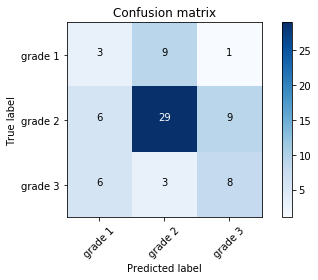

In [17]:
lr = LogisticRegression(solver='liblinear', multi_class='auto', penalty='l1', C=10.**c, random_state=0)
lr.fit(sbs_train_std, y_train)
lr_predict = lr.predict(sbs_test_std)

print('Test accuracy:', lr.score(np.array(sbs_test_std), y_test))

cnf_matrix = confusion_matrix(y_test, lr_predict)
np.set_printoptions(precision = 3)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['grade 1','grade 2','grade 3'], title='Confusion matrix')
plt.show()


### ii) KNeighborsClassifier
```Similar to logistic regression, KNN also appears to be relatively well classified in stage 2, but it is significantly less accurate than other classifiers.```

Test accuracy: 0.527027027027027
Confusion matrix, without normalization
[[ 4  9  0]
 [11 32  1]
 [ 5  9  3]]


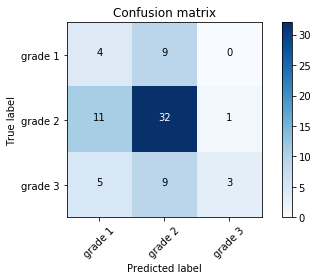

In [18]:
knn = KNeighborsClassifier(n_neighbors=2, p=2, metric='minkowski')
knn.fit(sbs_train_std, y_train)
knn_predict = knn.predict(sbs_test_std)

print('Test accuracy:', knn.score(np.array(sbs_test_std), y_test))

cnf_matrix = confusion_matrix(y_test, knn_predict)
np.set_printoptions(precision = 3)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['grade 1','grade 2','grade 3'], title='Confusion matrix')
plt.show()

### iii) RandomForestClassifier
```The accuracy of the random forest is highest among the five models, and the second and third grade are well classified. However the classification of grade1 is very weak. Therefore, the accuracy is the highest, but we can not be sure that it is the best classifier.```

Test accuracy: 0.6756756756756757
Confusion matrix, without normalization
[[ 0 13  0]
 [ 0 44  0]
 [ 0 11  6]]


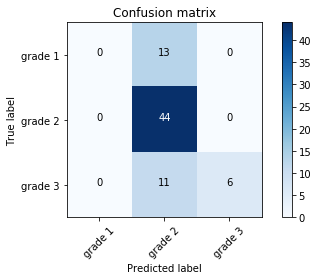

In [19]:
rf = RandomForestClassifier(criterion='entropy', 
                                n_estimators=500, 
                                max_features='sqrt', 
                                max_depth=None,
                                random_state=1,
                                n_jobs=2)
rf.fit(sbs_train_std, y_train)
rf_predict = rf.predict(sbs_test_std)

print('Test accuracy:', rf.score(np.array(sbs_test_std), y_test))

cnf_matrix = confusion_matrix(y_test, rf_predict)
np.set_printoptions(precision = 3)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['grade 1','grade 2','grade 3'], title='Confusion matrix')
plt.show()


### iV) Decision tree
```Decision trees seems to be a relatively good classifier compared to the previous models. There is an error rate but classifies the grade relatively well.```

Test accuracy: 0.6081081081081081
Confusion matrix, without normalization
[[ 6  6  1]
 [ 4 30 10]
 [ 3  5  9]]


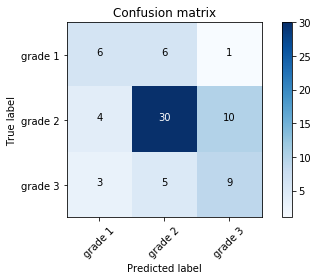

In [20]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=1)
tree.fit(sbs_train_std, y_train)
tree_predict = tree.predict(sbs_test_std)

print('Test accuracy:', tree.score(np.array(sbs_test_std), y_test))

cnf_matrix = confusion_matrix(y_test, tree_predict)
np.set_printoptions(precision = 3)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['grade 1','grade 2','grade 3'], title='Confusion matrix')
plt.show()


### v) MajorityVoteClassifier
```This model is the second most accurate model after randomforest.
There is no significant difference in accuracy compared to randomforest, and grade 1 seems to be relatively well classified. It can be said that it is the best classifier among the classifiers so far.```

In [21]:
class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))


        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

Test accuracy: 0.6621621621621622
Confusion matrix, without normalization
[[ 6  6  1]
 [ 4 30 10]
 [ 3  5  9]]


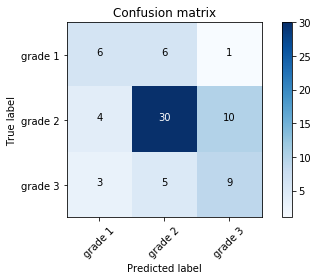

In [22]:
mv_clf = MajorityVoteClassifier(classifiers=[lr, rf, tree])
mv_clf.fit(sbs_train_std, y_train)
mv_clf_predict = mv_clf.predict(sbs_test_std)


print('Test accuracy:', accuracy_score(y_test, mv_clf_predict))

accuracy_score(y_test, mv_clf_predict)

cnf_matrix = confusion_matrix(y_test, tree_predict)
np.set_printoptions(precision = 3)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['grade 1','grade 2','grade 3'], title='Confusion matrix')
plt.show()

#### Summarization

```As a result of the study, the accuracy of test was high in order of randomforest, majority voting, decision tree, logistic regression, KNN. Random forests, however, have high test accuracy but severe overfitting.
On the other hand, the majority voting has little difference in accuracy from randomforest, and is also relatively strong in overfitting. Therefore, the majority voting, which summarizes the results of several models according to the majority and predicts the results, is good.```

In [23]:
sbs_train_std.columns

Index(['ABCC5', 'ABCC8', 'ABCG2', 'AC055720.2', 'AC099329.1', 'AC118459.2',
       'AC253536.7', 'ACOX1', 'ACP6', 'ACSL5', 'ACYP1', 'ADRB2', 'AK1',
       'AL096829.1', 'AL121994.1', 'ANGPTL2', 'ANGPTL4', 'ANK3', 'APLP1',
       'ASB13', 'AZIN1', 'BANF1', 'BCL2L13', 'BUB3', 'CBR1', 'CDC42BPB',
       'CDH18', 'CLEC10A', 'CRAT', 'CRBN', 'CSRP1', 'EDN1', 'ELP5', 'ME3',
       'OLR1', 'SLC1A4'],
      dtype='object')